# Combing Likelihoods
The following code helps you create KDE data off of likelihoods generated from various bilby runs

1. get_H0_KDE:\
Returns a posterior density distirbution KDE for H0 based
on the set of input distance samples associated with a given event/instance


2. get_mod_likelihood:\
Returns a likelihood (mod evidence) KDE for H0 based
on the set of input distance samples associated with a given event/instance



3. get_dir_bilby_data:\
given that your in a bilby_run_... dir, this script pulls all data


4. plot_kde_sample_comparsion\
After you generated a KDE for a set of data, you may want to compare that KDE to the 
original data to make sure they match up appropriatly. This code  Returns a plot 
    displaying sample H0 values overlayed with the outline of a KDE distribution, to 
    confirm if your code is working or not
    
    
# Sampling Likelihoods
To sample the likelihoods, we have two options. On one hand we could use EMCEE, on another hand we can
use some built-in python functions. Since the distribution is one dimensional, we opt to currently
use the built-in python functions

we then have the following methods:


1. get_likelihood_via_path:\
this function returns the distance likelihood KDE associated with some bilby distribution, and true distance, by feeding in the path name to the result.json file within the output directory.


2. sample_likelihood:\
This function takes in the likelihood generated by the above funtion, as well as an appropriate H0 axis and number of samples to be performed, and returns (A) an array of samples from the likelihood, and (B) a plot displaying the sample distibrution. Since we're currently assuming a uniform prior, the likelihood samples are directly proportional to the actual posterior, so by normalizing we still obtain the correct posterior for H0 given the gravitaitonal wave distance data. 



Below that we have a few examples of this code being applied

In [1]:
import os
from matplotlib import pyplot
%matplotlib inline
import numpy as np
import seaborn as sns
import json 
import pickle
import bilby
import get_bilby_data as gbd
from sklearn.neighbors import KernelDensity
import random

In [2]:
def get_H0_KDE(lum_d_samples, zt, di, df, N):
    '''
    Returns a posterior density distirbution KDE for H0 based
    on the set of input distance samples associated with a given event/instance
    
    PARAMETERS:
    ----------
        lum_d_samples: a python array object containing sampled distance positions
        zt: a redshift value associated with the event
        di: the bottom of the distance sampling interval [di, df]
        df: the top of the distance sampling interval [di, df]
        N: the step size of the distance sampling interval 
    '''

    #set a value for C
    c=299792.45
    
    #convert the data into a numpy array
    d_samples=np.array(lum_d_samples)
    
    #build the H0 histogram 
    H0_samples=zt*c/d_samples
    
    #given that the distance samples range over [di, df], resolution N,
    #create and H0 axis with the appropriate parameters 
    H0_axis = np.linspace(zt*c/df, zt*c/di, N)

    #create the probability density via KDE process 
    kde = KernelDensity(bandwidth=1.0, kernel='gaussian')
    kde.fit(H0_samples[:, None])
    logprob = kde.score_samples(H0_axis[:, None])
    H0_D=np.exp(logprob)
    

    #return H0 posterior 
    return H0_D


In [3]:
def get_mod_likelihood(posterior, zt, di, df, N):
    
    '''
    Returns a likelihood (mod evidence) KDE for H0 based
    on the set of input distance samples associated with a given event/instance
    
    PARAMETERS:
    ----------
        posteiror: posterior density distirbution KDE for H0
        zt: a redshift value associated with the event
        di: the bottom of the distance sampling interval [di, df]
        df: the top of the distance sampling interval [di, df]
        N: the step size of the distance sampling interval 
    '''
    
    #set a value for C
    c=299792.45
    
    #build a uniform H0 prior over the range [Hi, Hf]
    Hi, Hf = zt*c/df, zt*c/di
    H0_prior=np.full(N, 1/(Hf-Hi))
    
    #test prior integral sums to ~1
    dH0=(Hf-Hi)/N
    #print('H0 prior sum test: ', sum(H0_prior)*dH0)
    
    #return the modified likelihood, e.g. the likelihood
    #without the evidence term
    mod_Likelihood=posterior/H0_prior
    
    return mod_Likelihood
    

In [4]:
def get_dir_bilby_data():
    
    '''given that your in a bilby_run_... dir, this script pulls all data'''
    
    ra_dec=[file[6:].split('_') for file in os.listdir() if file[:5]=='bilby']
    ra_dec=[ [float(ra_dec[i][0]),float(ra_dec[i][1])] for i in range(len(ra_dec))]

    #get full result.json data for each run, and place it in 'data' array
    data=[]
    for run in ra_dec:
        path='bilby_{}_{}/bilby_{}_{}_result.json'.format(run[0],run[1],run[0],run[1])
        result=gbd.get_bilby_data(path)
        data.append(result)
    
    return data

In [5]:
def plot_kde_sample_comparsion(lum_dist, H0):
    '''
    Returns a plot displaying sample H0 values overlayed 
    
    PARAMETERS:
    ----------
        posteiror: posterior density distirbution KDE for H0
        zt: a redshift value associated with the event
        di: the bottom of the distance sampling interval [di, df]
        df: the top of the distance sampling interval [di, df]
        N: the step size of the distance sampling interval 
    ''' 

    c=299792.45
    
    #define H0 interval start/end-points, differential, and axis
    Hi, Hf = zt*c/df, zt*c/di
    dH0=(Hf-Hi)/N
    H0_axis=np.linspace(Hi, Hf, N)

    data_copy=np.array(lum_dist)  #copy over data
    h0_data=c*zt/data_copy        #convert distance samples to H0 samples 

    pyplot.rcParams.update({'font.size': 18})
    pyplot.figure(figsize=(12,10))

    pyplot.plot(H0_axis,H0_GW_posterior, alpha=1,color=(1,0,0))  #plot KDE
    pyplot.hist(h0_data, bins=200, alpha=0.4, density=True);     #plot h0_data
    ax = pyplot.gca()
    ylim = ax.get_ylim()
    pyplot.plot([H0, H0], ylim, 'r--')
    pyplot.ylim(ylim)
    pyplot.show()

In [6]:
#import data
path="bilby_0.4_0.73_followup_2/bilby_0.4_0.73_followup_2_result.json"
data=gbd.get_bilby_data(path)
lum_dist=data[0][5]


#define 'by-run' constants/static constants
d_true, di, df = 50, 10, 1000
N=1000

H0_true, c = 70, 299792.45
zt = d_true*H0_true/c


#define H0 interval start/end-points, differential, and axis
Hi, Hf = zt*c/df, zt*c/di
dH0=(Hf-Hi)/N
H0_axis=np.linspace(Hi, Hf, N)


#build posterior
H0_GW_posterior=get_H0_KDE(lum_dist, zt, di, df, N)

#test that sums evaluate properly over H0
print('H0 posterior sum test: ', sum(H0_GW_posterior)*dH0)


#define likelihood
likelihood=get_mod_likelihood(H0_GW_posterior, zt, di, df, N)


#plot
pyplot.fill_between(H0_axis, likelihood, alpha=1,color=(0,0,1))
ax = pyplot.gca()
ylim = ax.get_ylim()
pyplot.plot([H0_true, H0_true], ylim, 'r--')
pyplot.ylim(ylim)
pyplot.show()

OSError: No result 'bilby_0.4_0.73_followup_2/bilby_0.4_0.73_followup_2_result.json' found

In [141]:
ls

README.md                      combing_likelihoods.ipynb
Untitled.ipynb                 get_bilby_data.py
__pycache__/                   graph_data_analysis .ipynb
bilby_runs_0.4_0.73/           likelihood_kde_notebook.ipynb
bilby_runs_3.0_-1.2/           meta_prior_analysis.py
bilby_runs_5.445_0/


In [11]:
def get_likelihood_via_path(dtrue, path, H0_true = 70 , c = 299792.45, di=10, df=1000, N=1000):
    '''
    this function returns the distance likelihood KDE associated with some bilby 
    distribution, and true distance, by feeding in the path name to the 
    result.json file within the output directory.

    PARAMETERS:
    ----------
        dtrue: true distance to source in Mpc
        path: the path name to the bilby result.json data to be read in
        H0_true: assumed H0 vlaue
        c: speed of light
        di: the bottom of the distance sampling interval [di, df]
        df: the top of the distance sampling interval [di, df]
        N: the step size of the distance sampling interval 
    '''
    
    path=path
    #calls gbd (file in dir) to get the data associated with path
    data=gbd.get_bilby_data(path)
    
    #returned data object has the distnace data in entry 0, column 5
    lum_dist=data[0][5]
    
    #compute artificial redshift 
    zt= dtrue*H0_true/c
    
    #use the previously defined methods to get the posterior/ the likelihood 
    H0_GW_posterior = get_H0_KDE(lum_dist, zt, di, df, N)
    likelihood = get_mod_likelihood(H0_GW_posterior, zt, di, df, N)
    
    return likelihood

In [20]:
def sample_likelihood(H0_axis, likelihood, k=100000):
    '''
    This function takes in the likelihood generated by the above funtion, 
    as well as an appropriate H0 axis and number of samples to be performed, 
    and returns (A) an array of samples from the likelihood, and (B) a 
    plot displaying the sample distibrution. Since we're currently assuming 
    a uniform prior, the likelihood samples are directly proportional to 
    the actual posterior, so by normalizing we still obtain the correct 
    posterior for H0 given the gravitaitonal wave distance data. 
    
    PARAMETERS:
    ----------
        H0_axis: a numpy array object containing a representation of
            the H0 axis, where the step size is determined by the 
            redhsift/ the code in the below block
        likelihood: a likelihood KDE returned from get_mod_lieklihood
            or get_likelihood_via_path method
        k: number of samples to perform 
    '''
    
    #sample points with weights according to the likelihood
    LH_samples=random.choices(H0_axis, likelihood, k=1000000)

    #get the proper resolution size for the sample histogram
    H_N=len(H0_axis)

    #histogram data/axis via numpy
    np_hist=np.histogram(LH_samples, H_N, density=True)  #<------ go back and change this
    
    #get samples
    np_samp=np_hist[0]


    #get axis; remove +1 axis size thing
    axis=np_hist[1][0:H_N]
    
    V1=sum(np_samp)     #  <------ go back and change this
    DV=axis[1]-axis[0]  #  <------ go back and change this
    print(V1*DV)        #  <------ go back and change this

    #scale likelihood KDE to a density
    posterior=likelihood/(sum(likelihood)*DV)

    #plot samples and true likelihood 
    pyplot.plot(axis,np_samp, alpha=0.3)
    
    pyplot.plot(H0_axis, posterior, 'r', linewidth=1)
    ax = pyplot.gca()
    ylim = ax.get_ylim()
    pyplot.plot([70, 70], ylim, 'r')
    pyplot.ylim([0,max(np_samp)+0.01])
    pyplot.xlim([0, 100])
    pyplot.xlabel("$H_0$ -  Hubbles Constant (Mpc)")
    pyplot.ylabel("$p(H_0)$")
    
    return axis    #<------ go back and change this

# Sample plots which apply the above code

In [13]:
#define 'by-run' constants/static constants
di, df = 10, 1000
N=1000

H0_true, c = 70, 299792.45


#define H0 interval start/end-points, differential, and axis
# Hi, Hf = zt*c/df, zt*c/di
# dH0=(Hf-Hi)/N
# H0_axis=np.linspace(Hi, Hf, N)

In [10]:
cd 

EMCEE_combining_likelihoods.ipynb  bilby_runs_5.445_0/
H0_sampling/                       comb_like_dos.ipynb
README.md                          combing_likelihoods.ipynb
__pycache__/                       get_bilby_data.py
bayestar_run_dir/                  graph_data_analysis .ipynb
bilby_runs_0.4_0.73/               likelihood_kde_notebook.ipynb
bilby_runs_2.239_1.346/            meta_prior_analysis.py
bilby_runs_3.0_-1.2/               running_bayestar.ipynb


3.5 350.0
0.9999999999999992


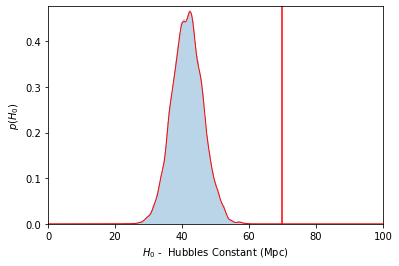

In [32]:
# get (0.4, 0.73) data
dtrue=50

zt=dtrue*H0_true/c
Hi, Hf = zt*c/df, zt*c/di
print(Hi,Hf)
dH0=(Hf-Hi)/N
H0_axis=np.linspace(0, 200, N)

L1_04_073 = get_likelihood_via_path(dtrue,
                "bilby_runs_0.4_0.73/bilby_0.4_0.73_followup_2/bilby_0.4_0.73_followup_2_result.json")

samp1=sample_likelihood(H0_axis, L1_04_073)

In [56]:
type(samp1[1]-samp1[0])

numpy.float64

1.0000000000000215
0.9999999999999972
0.9999999999999883


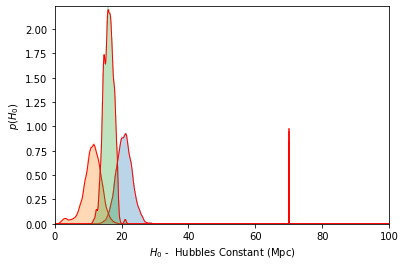

In [34]:
# get (0.4, 0.73) data
dtrue=50

zt=dtrue*H0_true/c
Hi, Hf = zt*c/df, zt*c/di
dH0=(Hf-Hi)/N
H0_axis=np.linspace(0, 100, N)
L1_04_073 = get_likelihood_via_path(dtrue,
                "bilby_runs_0.4_0.73/bilby_0.4_0.73_followup_2/bilby_0.4_0.73_followup_2_result.json")

samp1=sample_likelihood(H0_axis, L1_04_073)

L2_04_073 = get_likelihood_via_path(dtrue,
                "bilby_runs_0.4_0.73/bilby_0.4_0.73_followup_trueloc/bilby_0.4_0.73_followup_trueloc_result.json")

samp2=sample_likelihood(H0_axis, L2_04_073)


LL_04_073= L1_04_073*L2_04_073

samp_joined_04_073=sample_likelihood(H0_axis, LL_04_073)


1.0000000000000075
0.9999999999999882
1.0000000000000728


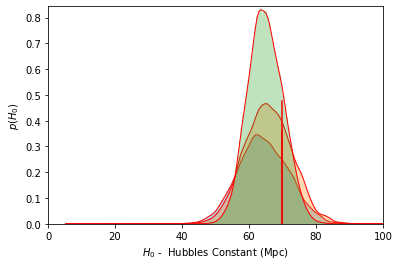

In [25]:
# get (3.0, -1.2) data
dtrue=75

zt=dtrue*H0_true/c
Hi, Hf = zt*c/df, zt*c/di
dH0=(Hf-Hi)/N
H0_axis=np.linspace(Hi, Hf, N)

L1_30_12 = get_likelihood_via_path(dtrue,
                "bilby_runs_3.0_-1.2/bilby_3.0_-1.2_followup/bilby_3.0_-1.2_followup_result.json")

samp1=sample_likelihood(H0_axis, L1_30_12)

L2_30_12 = get_likelihood_via_path(dtrue,
                "bilby_runs_3.0_-1.2/bilby_3.0_-1.2/bilby_3.0_-1.2_result.json")

samp2=sample_likelihood(H0_axis, L2_30_12)


LL_30_12= L1_30_12*L2_30_12

samp_joined_30_12=sample_likelihood(H0_axis, LL_30_12)

/Users/rickwilde/Desktop/Fall 2021/summer_research/git/GW_Bilby_Events/bilby_runs/get_bilby_data.py:15: RuntimeWarning: overflow encountered in exp
  likelihood=np.exp(log_likelihood)


1.0000000000000322


/Users/rickwilde/Desktop/Fall 2021/summer_research/git/GW_Bilby_Events/bilby_runs/get_bilby_data.py:15: RuntimeWarning: overflow encountered in exp
  likelihood=np.exp(log_likelihood)


1.0000000000000016
0.9999999999999555


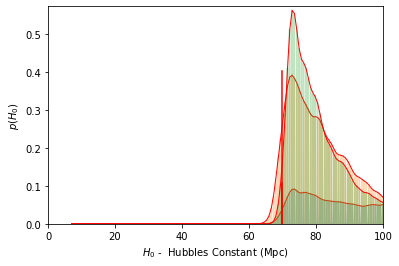

In [24]:
# get (5.445, 0.0) data
dtrue=100

zt=dtrue*H0_true/c
Hi, Hf = zt*c/df, zt*c/di
dH0=(Hf-Hi)/N
H0_axis=np.linspace(Hi, Hf, N)

L1_54_00 = get_likelihood_via_path(dtrue,
                "bilby_runs_5.445_0/bilby_5.445_0_followup/bilby_5.445_0_followup_result.json")

samp1=sample_likelihood(H0_axis, L1_54_00)

L2_54_00 = get_likelihood_via_path(dtrue,
                "bilby_runs_5.445_0/bilby_5.445_0_followup_trueloc/bilby_5.445_0_followup_trueloc_result.json")

samp2=sample_likelihood(H0_axis, L2_54_00)


LL_54_00= L1_54_00*L2_54_00

samp_joined_54_00=sample_likelihood(H0_axis, LL_54_00)

1.00000000000002
0.999999999999982
0.9999999999999755


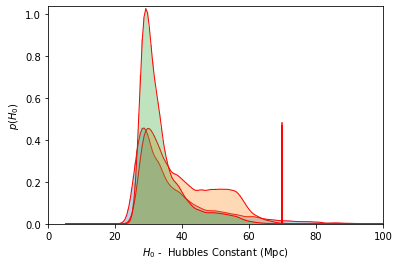

In [23]:
# get (2.239, 1.346) data
dtrue=75

zt=dtrue*H0_true/c
Hi, Hf = zt*c/df, zt*c/di
dH0=(Hf-Hi)/N
H0_axis=np.linspace(Hi, Hf, N)

L1_22_13 = get_likelihood_via_path(dtrue,
                "bilby_runs_2.239_1.346/bilby_runs_2.239_1.346_followup/bilby_2.239_1.346_followup_result.json")

samp1=sample_likelihood(H0_axis, L1_22_13)

L2_22_13 = get_likelihood_via_path(dtrue,
                "bilby_runs_2.239_1.346/bilby_runs_2.239_1.346_followup_trueloc/bilby_2.239_1.346_followup_trueloc_result.json")

samp2=sample_likelihood(H0_axis, L2_22_13)


LL_22_13= L1_22_13*L2_22_13

samp_joined_22_13=sample_likelihood(H0_axis, LL_22_13)

1.0000000000000537


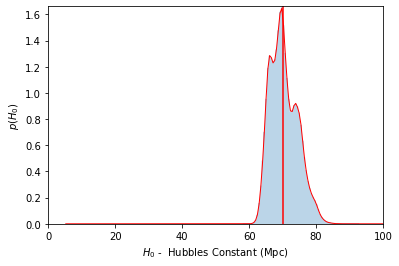

In [28]:
total=LL_54_00*LL_30_12*LL_04_073
sample_likelihood(H0_axis, total);

1.0000000000000107
1.000000000000089


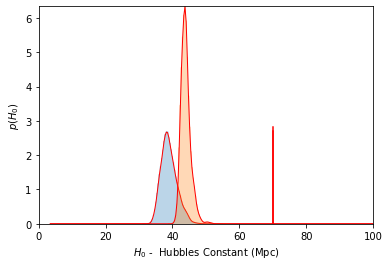

In [28]:
total_true=L2_54_00*L2_30_12*L2_04_073*L2_22_13
sample_likelihood(H0_axis, total_true);

total=LL_54_00*LL_30_12*LL_04_073*LL_22_13
sample_likelihood(H0_axis, total);

0.9999999999999156


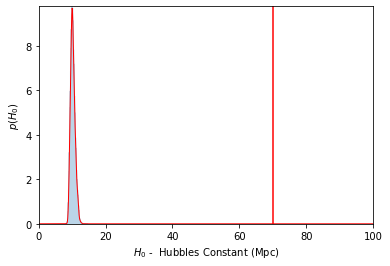

In [31]:
total_true=L2_54_00*L2_30_12*L2_04_073*L2_22_13
sample_likelihood(np.linspace(0,100,1000), total_true);